# Principal Component Analysis (PCA)
We will implement the PCA algorithm. We will first implement PCA, then apply it (once again) to the MNIST digit dataset.

## Learning objective
1. Write code that implements PCA.
2. Write code that implements PCA for high-dimensional datasets

Let's first import the packages we need for this week.

In [1]:
# PACKAGE: DO NOT EDIT
import numpy as np
import scipy
import scipy.stats

In [2]:
import matplotlib.pyplot as plt
from ipywidgets import interact

plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
from load_data import load_mnist
MNIST = load_mnist('./')
images, labels = MNIST['data'], MNIST['target']

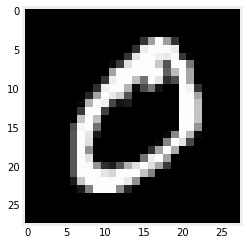

In [4]:
plt.figure(figsize=(4,4))
plt.imshow(images[0].reshape(28,28), cmap='gray');
plt.grid(False)

## PCA

Now we will implement PCA. Before we do that, let's pause for a moment and
think about the steps for performing PCA. Assume that we are performing PCA on
some dataset $\boldsymbol X$ for $M$ principal components. 
We then need to perform the following steps, which we break into parts:

1. Data normalization (`normalize`).
2. Find eigenvalues and corresponding eigenvectors for the covariance matrix $S$.
   Sort by the largest eigenvalues and the corresponding eigenvectors (`eig`).
3. Compute the orthogonal projection matrix and use that to project the data onto the subspace spanned by the eigenvectors.

Now, let's plot a digit from the dataset:

### Data normalization `normalize`

We will first implement the data normalization mentioned above.

Before we implement the main steps of PCA, we will need to do some data preprocessing.

To preprocess the dataset for PCA, we will make sure that the dataset has zero mean. Given a dataset $\mathbf{X}$, we will subtract the mean vector from each row of the dataset to obtain a zero-mean dataset $\overline{\mathbf{X}}$. In the first part of this notebook, you will implement `normalize` to do that.

To work with images, it's also a common practice to convert the pixels from unsigned interger 8 (uint8) encoding to a floating point number representation between 0-1. We will do this conversion for you for the MNIST dataset so that you don't have to worry about it.

Data normalization is a common practice. More details can be found in
[Data Normalization or Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling).

Some test cases that check the implementation of PCA

In [5]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE
def normalize(X):
    mu = X.mean(0)
    Xbar = X-mu
    return Xbar, mu
        

In [6]:
"""Test data normalization"""
from numpy.testing import assert_allclose

X0 = np.array([[0, 0.0],
               [1.0, 1.0],
               [2.0, 2.0]])
X0_normalize, X0_mean = normalize(X0)
# Test that normalized data has zero mean
assert_allclose(np.mean(X0_normalize, 0), np.zeros((2,)))
assert_allclose(X0_mean, np.array([1.0, 1.0]))
X0 = np.array([[0, 0.0],
               [1.0, 1.0],
               [2.0, 2.0]])
X0_normalize, X0_mean = normalize(X0)
# Test that normalized data has zero mean
assert_allclose(np.mean(X0_normalize, 0), np.zeros((2,)))
assert_allclose(X0_mean, np.array([1.0, 1.0]))


In [7]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE

def eig(S):
   
    eigvalues, eigvectors = np.linalg.eig(S)
    sort_indices = np.argsort(eigvalues)[::-1]
    return(eigvalues[sort_indices], eigvectors[:, sort_indices])

In [8]:
def _flip_eigenvectors(B): 
     signs = np.sign(B[np.argmax(np.abs(B), axis=0), range(B.shape[1])])
     return B * signs


def _normalize_eigenvectors(B):
   # Normalize eigenvectors to have unit length
   # Also flip the direction of the eigenvector based on # the first element
    B_normalized = B / np.linalg.norm(B, axis=0)
    for i in range(B.shape[1]):
            if (B_normalized[0, i] < 0):
                B_normalized[:, i] = -B_normalized[:, i]
    return B_normalized

A = np.array([[3, 2], [2, 3]])
expected_eigenvalues = np.array([5., 1.]) 
expected_eigenvectors = np.array(
[[ 0.70710678, -0.70710678],
[ 0.70710678,	0.70710678]]
)
actual_eigenvalues, actual_eigenvectors = eig(A)
assert_allclose(actual_eigenvalues, expected_eigenvalues)
assert_allclose(
          _normalize_eigenvectors(actual_eigenvectors),
          _normalize_eigenvectors(expected_eigenvectors),
)

In [9]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE
def projection_matrix(B):
    
    P = P = B @ np.linalg.inv(B.T @ B) @ B.T # EDIT THIS
    return P

In [10]:
B = np.array([[1, 0],
              [1, 1],
              [1, 2]])

assert_allclose( projection_matrix(B), np.array([[5, 2, -1],
                                                 [2, 2,  2],
                                                 [-1, 2, 5]]) / 6
)

In [11]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE
def PCA(X, num_components):
     N, D = X.shape
     X_normalized, mean = normalize(X)
     S = np.cov(X_normalized/ N, rowvar=False, bias=True)
     eig_vals, eig_vecs = eig(S)
     principal_vals = eig_vals[:num_components] 
     principal_components = eig_vecs[:, :num_components]
     P = projection_matrix(principal_components)
     reconst = (P @ X_normalized.T).T + mean
     return reconst, mean, principal_vals, principal_components

In [13]:
def draw_vector(v0, v1, ax=None, label=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->', linewidth=2, shrinkA=0)
    

In [14]:
D = 2
N = 10
mvn = scipy.stats.multivariate_normal( 
    mean=np.ones(D, dtype=np.float64),
    cov=np.array([[1, 0.8], [0.8, 1]], dtype=np.float64)
)

X = mvn.rvs((N,), random_state=np.random.RandomState(0)) 
reconst, m, pv, pc = PCA(X, 1)
assert reconst.shape == X.shape
assert m.shape == (D, ) 
assert pv.shape == (1, ) 
assert pc.shape == (D, 1)

reconst, m, pv, pc = PCA(X, D) 
assert reconst.shape == X.shape 
assert m.shape == (D, )
assert pv.shape == (2, ) 
assert pc.shape == (D, 2) 
assert_allclose(reconst, X)

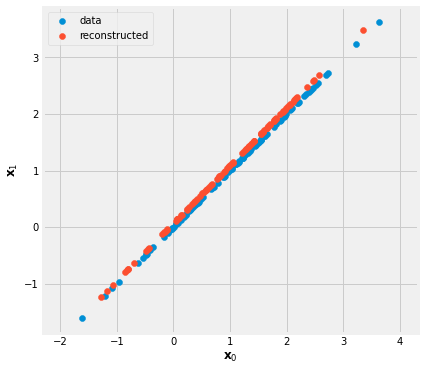

In [15]:
mvn = scipy.stats.multivariate_normal( 
    mean=np.ones(2),
    cov=np.array([[1, 0.8], [0.8, 1]])
)
X = mvn.rvs((100,), random_state=np.random.RandomState(0))
num_components = 1
X_reconst, mean, principal_values, principal_components = PCA(X, num_components)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[:, 1], X[:, 1], label='data')
for (principal_variance, principal_component) in (zip(principal_values, principal_components.T)):
    draw_vector(mean, mean + np.sqrt(principal_variance) * principal_component, ax=ax)
ax.scatter(X_reconst[:, 0], X_reconst[:, 1], label='reconstructed')
plt.axis('equal');
plt.legend();
ax.set(xlabel='$\mathbf{x}_0$', ylabel='$\mathbf{x}_1$');   

In [16]:
random = np.random.RandomState(0) 
X = random.randn(10, 5)

from sklearn.decomposition import PCA as SKPCA
for num_component in range(1, 4):

    pca = SKPCA(n_components=num_component, svd_solver="full") 
    sklearn_reconst = pca.inverse_transform(pca.fit_transform(X)) 
    reconst, _, _, _ = PCA(X, num_component)

    print("difference in reconstruction for num_components = {}: {}".format( num_component, np.square(reconst - sklearn_reconst).sum()
    )
  )
    np.testing.assert_allclose(reconst, sklearn_reconst)



difference in reconstruction for num_components = 1: 3.4416233291103798e-28
difference in reconstruction for num_components = 2: 1.3798459901658458e-28
difference in reconstruction for num_components = 3: 7.89881648091537e-29


In [26]:
## Some preprocessing of the data # NUM_DATAPOINTS = 1000
# X = (images.reshape(-1, 28 * 28)[:NUM_DATAPOINTS]) / 255.
## Some preprocessing of the data
NUM_DATAPOINTS = 1000
X = (images.reshape(-1, 28 * 28)[:NUM_DATAPOINTS]) / 255. 
Xbar, mu, std = normalize(X)

ValueError: not enough values to unpack (expected 3, got 2)

In [18]:
for num_component in range(1, 20):
    from sklearn.decomposition import PCA as SKPCA

    pca = SKPCA(n_components=num_component, svd_solver='full') 
    sklearn_reconst = pca.inverse_transform(pca.fit_transform(Xbar))  
    reconst = PCA(Xbar, num_component) 
    np.testing.assert_almost_equal(reconst, sklearn_reconst)
    print(np.square(reconst - sklearn_reconst).sum())


NameError: name 'Xbar' is not defined

In [19]:
def mse(predict, actual):
    return np.square(predict - actual).sum(axis=1).mean()

In [20]:
loss = [] 
reconstructions = []
# iterate over different number of principal components, and compute the MSE
for num_component in range(1, 50): 
    reconst = PCA(Xbar, num_component) 
    error = mse(reconst, Xbar) 
    reconstructions.append(reconst)
    
    loss.append((num_component, error))
    
reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions * std + mu
loss = np.asarray(loss)

NameError: name 'Xbar' is not defined

In [21]:
import pandas as pd
# create a table showing the number of principal components and MSE
pd.DataFrame(loss, columns=['no. of components', 'mse']).head()

,no. of components,mse


TypeError: list indices must be integers or slices, not tuple

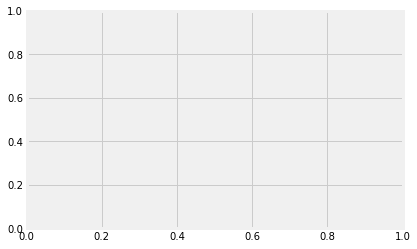

In [22]:
fig, ax = plt.subplots() 
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(10, linestyle='--', color='r', linewidth=2) 
ax.xaxis.set_ticks(np.arange(1, 100, 5));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

interactive(children=(IntSlider(value=500, description='image_idx', max=1000), Output()), _dom_classes=('widge…

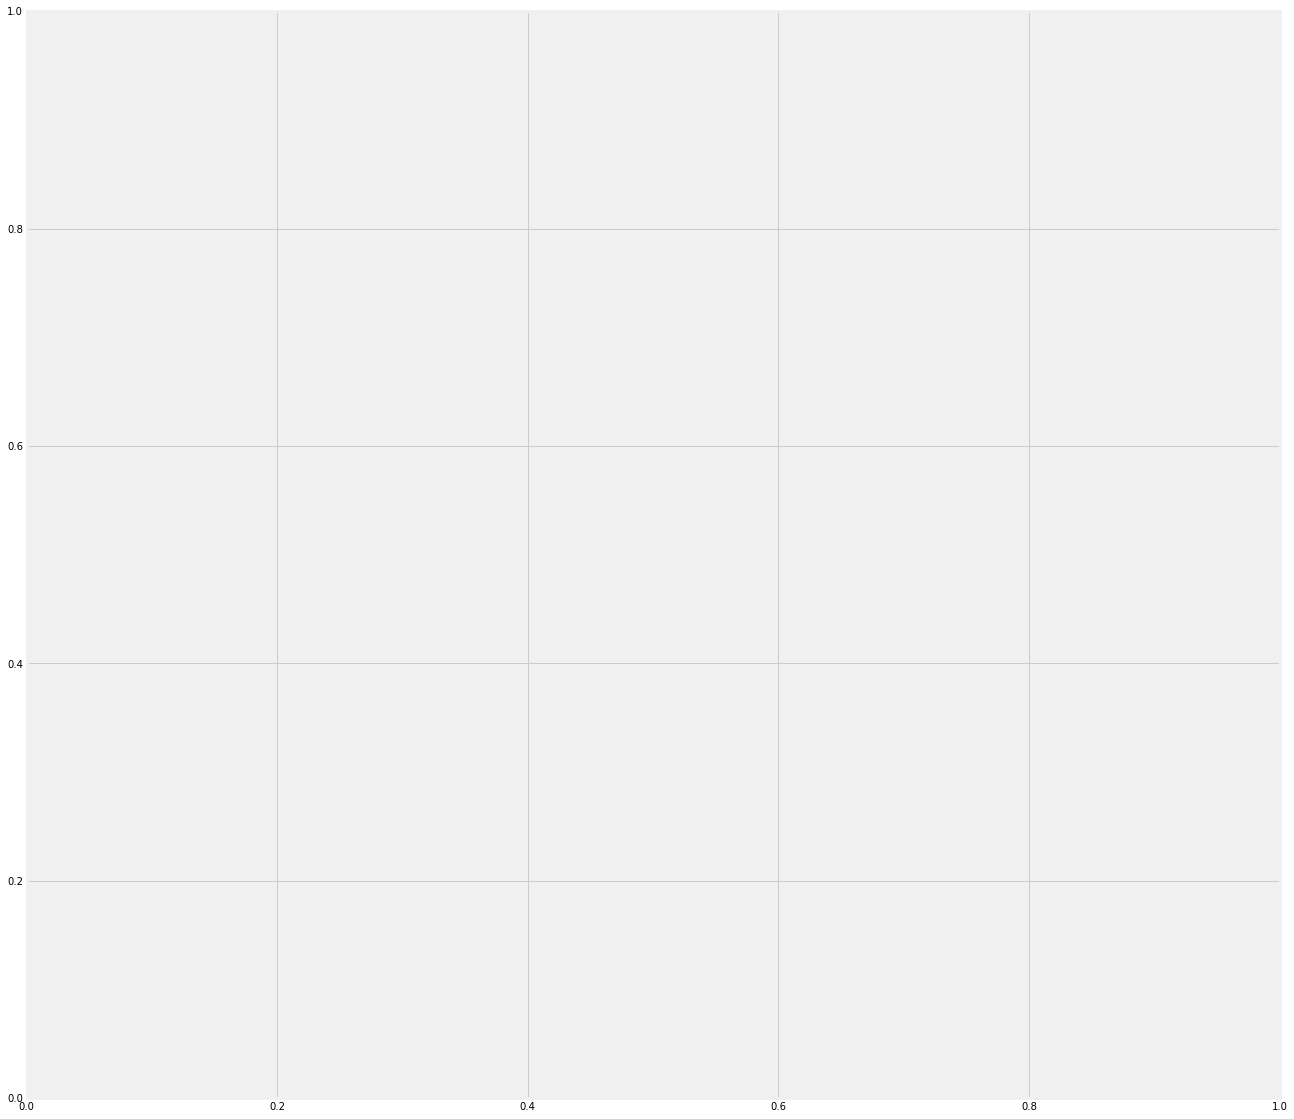

In [23]:
@interact(image_idx=(0, 1000))
def show_num_components_reconst(image_idx): 
    fig, ax = plt.subplots(figsize=(20., 20.)) 
    actual = X[image_idx]
    x = np.concatenate([actual[np.newaxis, :], reconstructions[:, image_idx]]) 
    x = np.real(x)
    ax.imshow(np.hstack(x.reshape(-1, 28, 28)[np.arange(10)]), cmap='gray');
    ax.axvline(28, color='orange', linewidth=2)

In [24]:
@interact(i=(0, 10))
def show_pca_digits(i=1):
    
    plt.figure(figsize=(4,4)) 
    actual_sample = X[i].reshape(28,28)
    reconst_sample = (reconst[i, :] * std + mu).reshape(28, 28) 
    actual_sample = np.real(actual_sample)
    reconst_sample = np.real(reconst_sample) 
    plt.imshow(np.hstack([actual_sample, reconst_sample]), cmap='gray') 
    plt.show()

interactive(children=(IntSlider(value=1, description='i', max=10), Output()), _dom_classes=('widget-interact',…

<Figure size 288x288 with 0 Axes>

## PCA for high-dimensional datasets

Sometimes, the dimensionality of our dataset may be larger than the number of samples we
have. Then it might be inefficient to perform PCA with your implementation above. Instead,
as mentioned in the lectures, you can implement PCA in a more efficient manner, which we
call "PCA for high dimensional data" (PCA_high_dim).

Below are the steps for performing PCA for high dimensional dataset
1. Normalize the dataset matrix $X$ to obtain $\overline{X}$ that has zero mean.
2. Compute the matrix $\overline{X}\overline{X}^T$ (a $N$ by $N$ matrix with $N << D$)
3. Compute eigenvalues $\lambda$s and eigenvectors $V$ for $\overline{X}\overline{X}^T$ with shape (N, N). Compare this with computing the eigenspectrum of $\overline{X}^T\overline{X}$ which has shape (D, D), when $N << D$, computation of the eigenspectrum of $\overline{X}\overline{X}^T$ will be computationally less expensive.
4. Compute the eigenvectors for the original covariance matrix as $\overline{X}^TV$. Choose the eigenvectors associated with the `n` largest eigenvalues to be the basis of the principal subspace $U$.
    1. Notice that $\overline{X}^TV$ would give a matrix of shape (D, N) but the eigenvectors beyond the Dth column will have eigenvalues of 0, so it is safe to drop any columns beyond the D'th dimension. 
    2. Also note that the columns of $U$ will not be unit-length if we pre-multiply $V$ with $\overline{X}^T$, so we will have to normalize the columns of $U$ so that they have unit-length to be consistent with the `PCA` implementation above.
5. Compute the orthogonal projection of the data onto the subspace spanned by columns of $U$. 

Functions you wrote for earlier assignments will be useful.

In [27]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE
### PCA for high dimensional datasets
def PCA_high_dim(X, num_components):
    """Compute PCA for small sample size. 
    Args:
        X: ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of data points in the training set. You may assume the input 
           has been normalized.
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: (N, D) ndarray. the reconstruction
        of X from the first `num_components` principal components.
    """
    N, D = X.shape
    M = (1/N) * (X @ X.T) # EDIT THIS, compute the matrix \frac{1}{N}XX^T.
    eig_vals, eig_vecs = eig(M) # EDIT THIS, compute the eigenvalues. 
    U = X.T @ eig_vecs # EDIT THIS. Compute the eigenvectors for the original PCA problem.
    # Similar to what you would do in PCA, compute the projection matrix,
    # then perform the projection.
    P = projection_matrix(U[: ,:num_components]) # projection matrix
    X_reconstruct = (P @ X.T).T # EDIT THIS.
    return X_reconstruct

In [28]:
def time(f, repeat=100):
    times = []
    for _ in range(repeat):
        start = timeit.default_timer()
        f()
        stop = timeit.default_timer()
        times.append(stop-start)
    return np.mean(times), np.std(times)

Given the same dataset, `PCA_high_dim` and `PCA` should give the same output. 
Assuming we have implemented `PCA`, correctly, we can then use `PCA` to test the correctness
of `PCA_high_dim`. Given the same dataset, `PCA` and `PCA_high_dim` should give identical results.

We can use this __invariant__
to test our implementation of PCA_high_dim, assuming that we have correctly implemented `PCA`.

In [30]:
times_mm0 = []
times_mm1 = []

for datasetsize in np.arange(4, 784, step=20):
    XX = Xbar[:datasetsize]
    mu, sigma = time(lambda : XX.T @ XX)
    times_mm0.append((datasetsize, mu, sigma))
    
    mu, sigma = time(lambda : XX @ XX.T)
    times_mm1.append((datasetsize, mu, sigma))
    
times_mm0 = np.asarray(times_mm0)
times_mm1 = np.asarray(times_mm1)

NameError: name 'Xbar' is not defined

_Congratulations_! You have now learned how PCA works!

TypeError: list indices must be integers or slices, not tuple

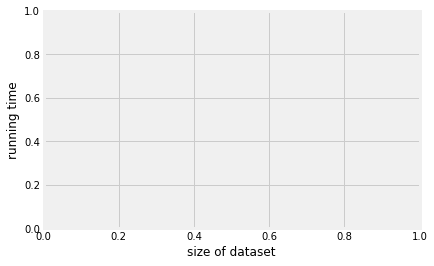

In [31]:
fig, ax = plt.subplots()
ax.set(xlabel='size of dataset', ylabel='running time')
bar = ax.errorbar(times_mm0[:, 0], times_mm0[:, 1], times_mm0[:, 2], label="$X^T X$ (PCA)", linewidth=2)
ax.errorbar(times_mm1[:, 0], times_mm1[:, 1], times_mm1[:, 2], label="$X X^T$ (PCA_high_dim)", linewidth=2)
ax.legend();

In [33]:
times0 = []
times1 = []

for datasetsize in np.arange(4, 784, step=100):
    XX = Xbar[:datasetsize]
    npc = 2
    mu, sigma = time(lambda : XX.T @ XX)
    times0.append((datasetsize, mu, sigma))
    
    mu, sigma = time(lambda : XX @ XX.T)
    times1.append((datasetsize, mu, sigma))
    
times0 = np.asarray(times0)
times1 = np.asarray(times1)

NameError: name 'Xbar' is not defined

In [34]:
%time Xbar.T @ Xbar
%time Xbar @ Xbar.T

NameError: name 'Xbar' is not defined

NameError: name 'Xbar' is not defined

TypeError: list indices must be integers or slices, not tuple

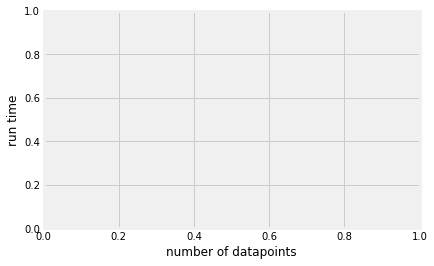

In [35]:
fig, ax = plt.subplots()
ax.set(xlabel='number of datapoints', ylabel='run time')
ax.errorbar(times0[:, 0], times0[:, 1], times0[:, 2], label="PCA", linewidth=2)
ax.errorbar(times1[:, 0], times1[:, 1], times1[:, 2], label="PCA_high_dim", linewidth=2)
ax.legend();

In [36]:
%time PCA(Xbar, 2)
%time PCA_high_dim(Xbar, 2)
pass

NameError: name 'Xbar' is not defined

NameError: name 'Xbar' is not defined